# Heart Disease Modeling Notebook
This notebook documents the steps taken to train and evaluate models for predicting heart disease.
All narrative, findings, and recommendations are written in English for inclusion in the project's GitHub.

Run cells sequentially. The `src.models` module contains helper functions used below.

In [1]:
# Data handling libraries
import pandas as pd
from pathlib import Path

In [2]:
# Modeling, evaluation and hyperparameter search libraries
import joblib
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

In [3]:
# Load cleaned dataset from project data folder
ROOT = Path.cwd().parent
path_raw = ROOT / "data" / "processed" / "heart_clean.csv"
df = pd.read_csv(path_raw)
# Inspect the first rows to confirm successful load
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
# Ensure project root is on sys.path so `src` can be imported
import sys
root = Path.cwd().parent
if str(root) not in sys.path:
    sys.path.append(str(root))

In [5]:
# Import helper functions from the local `src.models` module
from src.models import (
    baseline,
    randomforest_basemodel,
    svc_basemodel,
    decisiontree_basemodel,
    xgboost_basemodel,
    logistic_regression_optuna,
    random_forest_optuna,
    svc_optuna,
    create_triple_stacking,
    plot_ensemble_importance,
)

In [6]:
# Evaluate a simple baseline model (Logistic Regression with default params)
# This provides a performance floor to compare more complex models against
baseline(df, "HeartDisease")

Resultados por fold: [0.91183036 0.92375283 0.89801136 0.91619318 0.93920455]
Media: 0.918 (+/- 0.027)
Confusion Matrix:
[[66  5]
 [11 68]]
Score in Training set: 0.860738255033557
Score in Test set: 0.8933333333333333

--- Informe de Clasificación (Test Set) ---
              precision    recall  f1-score   support

           0       0.86      0.93      0.89        71
           1       0.93      0.86      0.89        79

    accuracy                           0.89       150
   macro avg       0.89      0.90      0.89       150
weighted avg       0.90      0.89      0.89       150

ROC-AUC Score in test: 0.9617
ROC-AUC Score in train: 0.9283


In [7]:
# Train and evaluate a Random Forest baseline to inspect non-linear performance
randomforest_basemodel(df, "HeartDisease")

Resultados por fold: [0.90987723 0.94061791 0.88039773 0.91789773 0.94517045]
Media: 0.919 (+/- 0.047)
Confusion Matrix:
[[67  4]
 [ 9 70]]
Score in Training set: 1.0
Score in Test set: 0.9133333333333333

--- Informe de Clasificación (Test Set) ---
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        71
           1       0.95      0.89      0.92        79

    accuracy                           0.91       150
   macro avg       0.91      0.91      0.91       150
weighted avg       0.92      0.91      0.91       150

ROC-AUC Score: 0.9583
ROC-AUC Score in train: 1.0000


In [8]:
# Evaluate a Support Vector Classifier baseline
svc_basemodel(df, "HeartDisease")

Resultados por fold: [0.90457589 0.92517007 0.90170455 0.90653409 0.93096591]
Media: 0.914 (+/- 0.024)
Confusion Matrix:
[[66  5]
 [10 69]]
Score in Training set: 0.9010067114093959
Score in Test set: 0.9

--- Informe de Clasificación (Test Set) ---
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        71
           1       0.93      0.87      0.90        79

    accuracy                           0.90       150
   macro avg       0.90      0.90      0.90       150
weighted avg       0.90      0.90      0.90       150

ROC-AUC Score: 0.9551
ROC-AUC Score in train: 0.9565


In [9]:
# Evaluate a Decision Tree baseline for interpretability comparisons
decisiontree_basemodel(df, "HeartDisease")

Resultados por fold: [0.77566964 0.80555556 0.70752841 0.73991477 0.75298295]
Media: 0.756 (+/- 0.066)
Confusion Matrix:
[[64  7]
 [14 65]]
Score in Training set: 1.0
Score in Test set: 0.86

--- Informe de Clasificación (Test Set) ---
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        71
           1       0.90      0.82      0.86        79

    accuracy                           0.86       150
   macro avg       0.86      0.86      0.86       150
weighted avg       0.86      0.86      0.86       150

ROC-AUC Score: 0.8621
ROC-AUC Score in train: 1.0000


In [10]:
# Evaluate an XGBoost baseline to capture boosted-tree performance
xgboost_basemodel(df, "HeartDisease")

Resultados por fold: [0.89006696 0.91241497 0.87755682 0.90085227 0.93721591]
Media: 0.904 (+/- 0.041)
Confusion Matrix:
[[67  4]
 [13 66]]
Score in Training set: 1.0
Score in Test set: 0.8866666666666667

--- Informe de Clasificación (Test Set) ---
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        71
           1       0.94      0.84      0.89        79

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150

ROC-AUC Score: 0.9472
ROC-AUC Score in train: 1.0000


### Observations and next steps
We observed that baseline models provide different performance characteristics (linear vs tree-based).
To improve results we perform hyperparameter optimization with Optuna and then build a stacked ensemble.

In [11]:
# Optimize Logistic Regression hyperparameters via Optuna
params_finales_lr = logistic_regression_optuna(df, "HeartDisease")

[I 2025-12-30 17:12:49,037] A new study created in memory with name: no-name-e5be4412-04b5-426b-99b9-40e8b1f9d4ab
[I 2025-12-30 17:12:49,136] Trial 0 finished with value: 0.5 and parameters: {'C': 0.0005687008172331411, 'solver': 'liblinear', 'penalty_lib': 'l1'}. Best is trial 0 with value: 0.5.
[I 2025-12-30 17:12:49,226] Trial 1 finished with value: 0.9224937122736419 and parameters: {'C': 0.050451683919192566, 'solver': 'saga', 'penalty_saga': 'l2'}. Best is trial 1 with value: 0.9224937122736419.
C:\Users\APUESTAS\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\APUESTAS\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\APUESTAS\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py

Confusion Matrix:
[[34  5]
 [ 2 34]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.91        39
           1       0.87      0.94      0.91        36

    accuracy                           0.91        75
   macro avg       0.91      0.91      0.91        75
weighted avg       0.91      0.91      0.91        75

ROC-AUC Score in test: 0.9558
ROC-AUC Score in train: 0.9314
score in training 0.8703427719821163
score in testing 0.9066666666666666


In [12]:
# Optimize Random Forest hyperparameters via Optuna
params_finales_rf = random_forest_optuna(df, "HeartDisease")

[I 2025-12-30 17:13:02,641] A new study created in memory with name: no-name-1c3d9def-cefb-4ad7-8379-f15e8b2bc504
[I 2025-12-30 17:13:03,020] Trial 0 finished with value: 0.9189716423541249 and parameters: {'n_estimators': 25, 'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 14, 'max_features': None, 'criterion': 'gini'}. Best is trial 0 with value: 0.9189716423541249.
[I 2025-12-30 17:13:06,304] Trial 1 finished with value: 0.9228175301810866 and parameters: {'n_estimators': 444, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 16, 'max_features': None, 'criterion': 'entropy'}. Best is trial 1 with value: 0.9228175301810866.
[I 2025-12-30 17:13:08,906] Trial 2 finished with value: 0.9275785965794767 and parameters: {'n_estimators': 369, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None, 'criterion': 'entropy'}. Best is trial 2 with value: 0.9275785965794767.
[I 2025-12-30 17:13:11,637] Trial 3 finished with value: 0.9269636569

Confusion Matrix:
[[34  5]
 [ 2 34]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.91        39
           1       0.87      0.94      0.91        36

    accuracy                           0.91        75
   macro avg       0.91      0.91      0.91        75
weighted avg       0.91      0.91      0.91        75

ROC-AUC Score in test: 0.9608
ROC-AUC Score in train: 0.9720
score in training 0.9001490312965723
score in testing 0.9066666666666666


In [13]:
# Optimize SVC hyperparameters via Optuna
params_finales_svc = svc_optuna(df, "HeartDisease")

[I 2025-12-30 17:13:36,688] A new study created in memory with name: no-name-968c32f4-6f0a-41ac-bfcc-796a71d62f54
[I 2025-12-30 17:13:36,971] Trial 0 finished with value: 0.9073019366197184 and parameters: {'C': 10.5353203302454, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.9073019366197184.
[I 2025-12-30 17:13:37,222] Trial 1 finished with value: 0.9222925050301811 and parameters: {'C': 0.5008130425326398, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 1 with value: 0.9222925050301811.
[I 2025-12-30 17:13:37,557] Trial 2 finished with value: 0.8715492957746479 and parameters: {'C': 476.23452732137963, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 1 with value: 0.9222925050301811.
[I 2025-12-30 17:13:37,704] Trial 3 finished with value: 0.9231187122736418 and parameters: {'C': 0.019096526260908537, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 3 with value: 0.9231187122736418.
[I 2025-12-30 17:13:38,005] Trial 4 finished with value: 0.9017152917505029 a

--- SVC OPTIMIZADO ---
[[34  5]
 [ 2 34]]
              precision    recall  f1-score   support

           0       0.94      0.87      0.91        39
           1       0.87      0.94      0.91        36

    accuracy                           0.91        75
   macro avg       0.91      0.91      0.91        75
weighted avg       0.91      0.91      0.91        75

ROC-AUC Score in test: 0.9487
ROC-AUC Score in train: 0.9295
score in training 0.8628912071535022
score in testing 0.9066666666666666


In [14]:
# Build a stacked ensemble from the tuned base models
modelo_ensamble_final = create_triple_stacking(
    df=df, 
    target="HeartDisease", 
    params_lr=params_finales_lr, 
    params_rf=params_finales_rf, 
    params_svc=params_finales_svc
)


--- RESULTADOS DEL ENSAMBLE TRIPLE ---
[[34  5]
 [ 2 34]]
              precision    recall  f1-score   support

           0       0.94      0.87      0.91        39
           1       0.87      0.94      0.91        36

    accuracy                           0.91        75
   macro avg       0.91      0.91      0.91        75
weighted avg       0.91      0.91      0.91        75

ROC-AUC Score in test: 0.9587
ROC-AUC Score in train: 0.9581
Score in testing: 0.9067
Score in training: 0.8852


## Findings
- Baseline logistic regression gives a reasonable starting point but is outperformed by tree-based models in AUC/recall in our experiments (see prior cells).
- Random forest and XGBoost capture non-linear interactions and generally provide better discrimination on this dataset.
- A stacked ensemble combining linear and tree-based learners tends to stabilize performance and can slightly improve overall AUC.


In [15]:
# Save final ensemble model to disk 
joblib.dump(modelo_ensamble_final, '../model/modelo_heart_disease_stacking.pkl')

['../model/modelo_heart_disease_stacking.pkl']

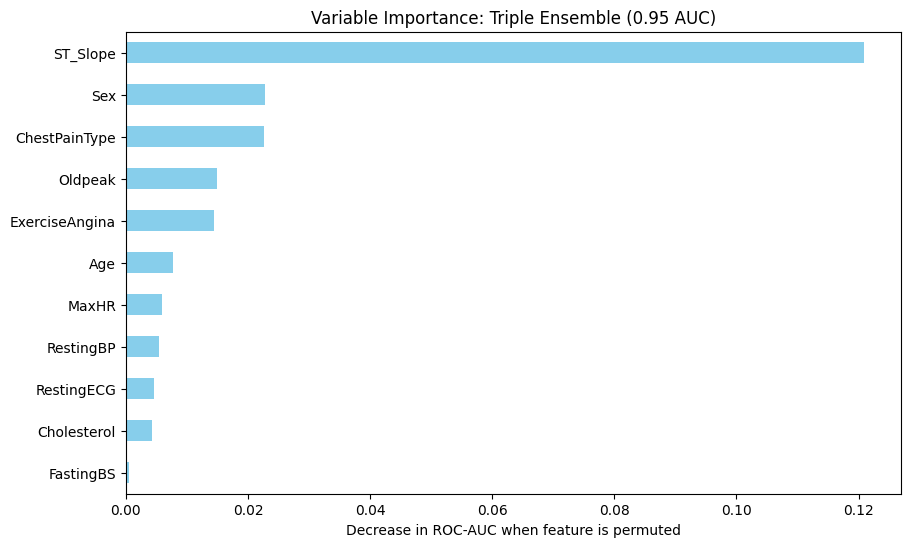

In [16]:
# Visualize feature importance for the ensemble
plot_ensemble_importance(modelo_ensamble_final, df.drop(columns=["HeartDisease"]), df["HeartDisease"])

#### Run this code in terminal to try the model 
#####  -python -m streamlit run app.py 